In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D

# Load your data
data = pd.read_csv("COMBINED_KOLKATA(2017-2022).csv")  # Ensure this file is in the same directory or provide full path

# Replace -999 with NaN and forward-fill missing values
data.replace(-999, np.nan, inplace=True)
data.fillna(method='ffill', inplace=True)

In [23]:
data.columns = data.columns.str.strip()

In [24]:
print(data.dtypes)


YEAR                   int64
MO                     int64
DY                     int64
PS                   float64
QV2M                 float64
PRECTOTCORR          float64
T2M                  float64
CLRSKY_SFC_SW_DWN    float64
ALLSKY_SFC_SW_DWN    float64
dtype: object


In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv("COMBINED_KOLKATA(2017-2022).csv") 




# RNN(LSTM)

In [26]:
# Normalization (Scaling to range [0,1])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Sequence generation for time-series prediction
sequence_length = 30  # Example window size
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length])
    y.append(data_scaled[i + sequence_length, 0])  # Assuming the target is the first column

X = np.array(X)
y = np.array(y)

In [30]:
# Split into training and testing sets
train_size = int(0.8 * len(X))
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


## Hyperparameter Tuning

In [31]:
pip install keras-tuner --upgrade

Note: you may need to restart the kernel to use updated packages.


In [32]:
import keras_tuner
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   return_sequences=True,
                   input_shape=(sequence_length, X.shape[2])))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=50, max_value=200, step=50)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='solar_irradiance_tuning'
)

tuner.search(X_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=32)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 03m 19s]
val_loss: 0.0004234936786815524

Best val_loss So Far: 0.0002527987599023618
Total elapsed time: 00h 56m 10s


C:\Users\bisha\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Best Hyperparameters

In [37]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Optimal number of units in the first LSTM layer: {best_hps.get('units')}")
print(f"Optimal dropout rate: {best_hps.get('dropout_rate')}")
print(f"Optimal number of units in the second LSTM layer: {best_hps.get('units2')}")
print(f"Optimal optimizer: {best_hps.get('optimizer')}")

Optimal number of units in the first LSTM layer: 200
Optimal dropout rate: 0.30000000000000004
Optimal number of units in the second LSTM layer: 150
Optimal optimizer: rmsprop


## Bi-Directional LSTM

In [38]:
# Define the bidirectional model with tuned hyperparameters
bidirectional_model = Sequential()

# First Bidirectional LSTM layer with 200 units
bidirectional_model.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=(sequence_length, X.shape[2])))

# Dropout layer with a rate of 0.3
bidirectional_model.add(Dropout(0.3))

# Second LSTM layer with 150 units
bidirectional_model.add(LSTM(150))

# Dense layer with 1 output neuron for regression
bidirectional_model.add(Dense(1))

# Compile the model with 'rmsprop' optimizer
bidirectional_model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Print the model summary to verify the architecture
bidirectional_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 30, 400)             │         336,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 400)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 150)                 │         330,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 666,751 (2.54 MB)

 Trainable params: 666,751 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

## Hybrid CNN-LSTM Model 

In [40]:
hybrid_model = Sequential()
hybrid_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(sequence_length, X.shape[2])))
hybrid_model.add(MaxPooling1D(pool_size=2))
hybrid_model.add(LSTM(50))
hybrid_model.add(Dense(1))
hybrid_model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\bisha\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
# Example: Train the bidirectional LSTM model
history = bidirectional_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - loss: 0.2184 - val_loss: 0.1285
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0154 - val_loss: 0.0717
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0076 - val_loss: 0.0211
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0048 - val_loss: 0.0157
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 0.0037 - val_loss: 4.3671e-04
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 0.0028 - val_loss: 6.5955e-04
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - loss: 0.0021 - val_loss: 0.0141
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0024 - val_loss: 7.4233e-04
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0021 - val_loss: 2.3720e-04
Epoch 12/50
54/54 ━━━━━━━━━━━━━━

In [43]:
# Predict on the test set
y_pred = bidirectional_model.predict(x_test)

# Ensure y_pred has the same number of columns as the original scaled data
y_pred_full = np.zeros((y_pred.shape[0], data_scaled.shape[1]))
y_pred_full[:, 0] = y_pred[:, 0]  # Populate only the target column

# Inverse transform
y_pred_rescaled = scaler.inverse_transform(y_pred_full)[:, 0]  # Extract the target column
y_test_rescaled = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), 
                                                      np.zeros((y_test.shape[0], data_scaled.shape[1] - 1))]))[:, 0]

# Now y_pred_rescaled and y_test_rescaled are comparable
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.19
R² Score: 0.73
Mean Absolute Percentage Error (MAPE): 0.01%


## PLOTS

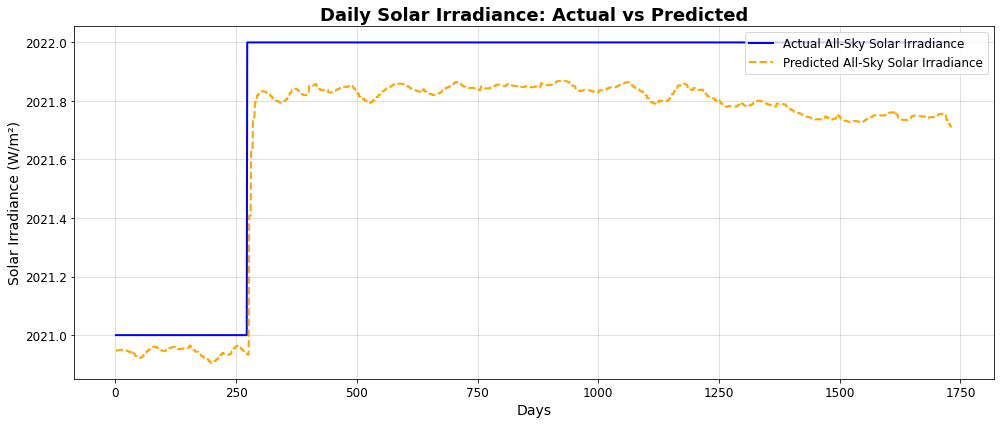

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure arrays are 2D (if not already done in earlier code)
y_test_rescaled = y_test_rescaled.reshape(-1, 1)
y_pred_rescaled = y_pred_rescaled.reshape(-1, 1)

# Generate day indices or use actual date labels if available
days = np.arange(1, len(y_test_rescaled) + 1)  # Day indices (1 to n)

# Visualization
plt.figure(figsize=(14, 6))

# Plot All-Sky Solar Irradiance
plt.plot(days, y_test_rescaled, label='Actual All-Sky Solar Irradiance', color='blue', linewidth=2)
plt.plot(days, y_pred_rescaled, label='Predicted All-Sky Solar Irradiance', color='orange', linestyle='dashed', linewidth=2)

# Titles and Labels
plt.title('Daily Solar Irradiance: Actual vs Predicted', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Solar Irradiance (W/m²)', fontsize=14)

# Grid, Legend, and Ticks
plt.legend(fontsize=12, loc='upper right')
plt.grid(alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout for a clean look
plt.tight_layout()

# Display the plot
plt.show()


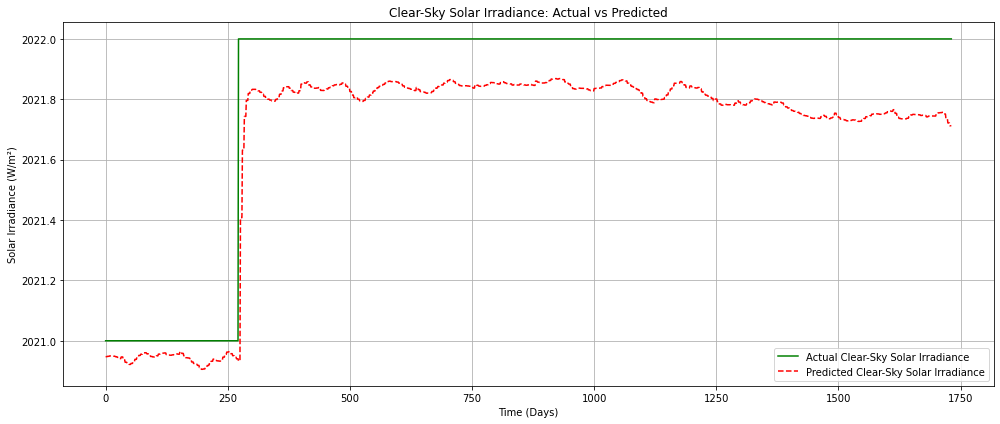

In [66]:
# Ensure arrays are 2D if not already
y_test_rescaled = y_test_rescaled.reshape(-1, 1)
y_pred_rescaled = y_pred_rescaled.reshape(-1, 1)

# Visualization of Clear-Sky Solar Irradiance
plt.figure(figsize=(14, 6))

plt.plot(y_test_rescaled, label='Actual Clear-Sky Solar Irradiance', color='green')
plt.plot(y_pred_rescaled, label='Predicted Clear-Sky Solar Irradiance', color='red', linestyle='dashed')
plt.title('Clear-Sky Solar Irradiance: Actual vs Predicted')
plt.xlabel('Time (Days)')
plt.ylabel('Solar Irradiance (W/m²)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### RESIDUAL PLOT

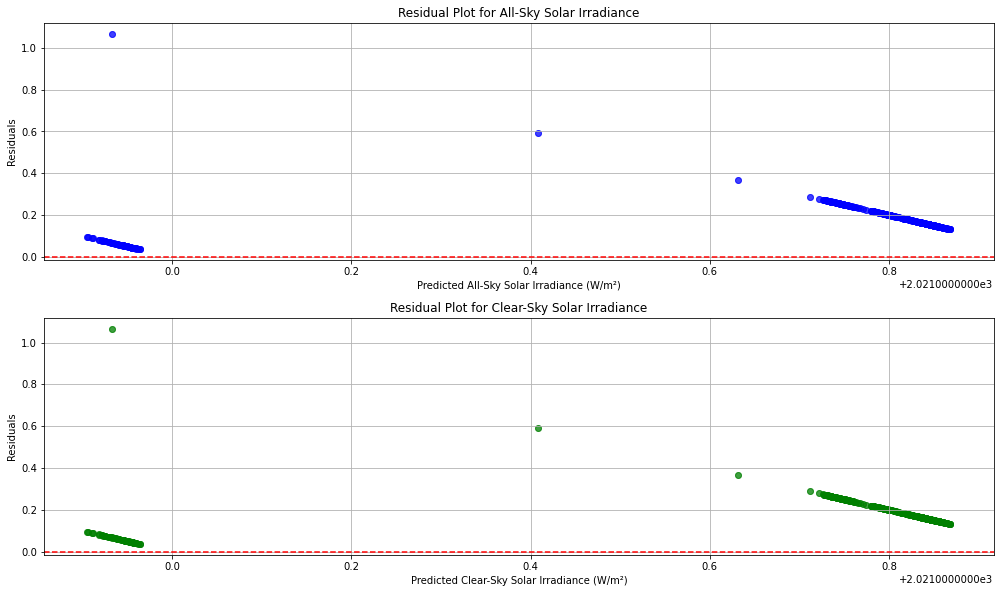

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure arrays are 2D if not already
y_test_rescaled = y_test_rescaled.reshape(-1, 1)
y_pred_rescaled = y_pred_rescaled.reshape(-1, 1)

# Add a dummy second column if the data only has one column (for demonstration purposes)
# Replace this step with your actual multi-column data
if y_test_rescaled.shape[1] == 1:
    y_test_rescaled = np.hstack([y_test_rescaled, y_test_rescaled])
    y_pred_rescaled = np.hstack([y_pred_rescaled, y_pred_rescaled])

# Calculate residuals
residuals_allsky = y_test_rescaled[:, -1] - y_pred_rescaled[:, -1]
residuals_clearsky = y_test_rescaled[:, -2] - y_pred_rescaled[:, -2]

# Create a figure for both plots
plt.figure(figsize=(14, 12))

# Residual plot for All-Sky Solar Irradiance
plt.subplot(3, 1, 1)
plt.scatter(y_pred_rescaled[:, -1], residuals_allsky, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for All-Sky Solar Irradiance')
plt.xlabel('Predicted All-Sky Solar Irradiance (W/m²)')
plt.ylabel('Residuals')
plt.grid()

# Residual plot for Clear-Sky Solar Irradiance
plt.subplot(3, 1, 2)
plt.scatter(y_pred_rescaled[:, -2], residuals_clearsky, color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for Clear-Sky Solar Irradiance')
plt.xlabel('Predicted Clear-Sky Solar Irradiance (W/m²)')
plt.ylabel('Residuals')
plt.grid()


# Adjust layout
plt.tight_layout()
plt.show()


### HISTOGRAM

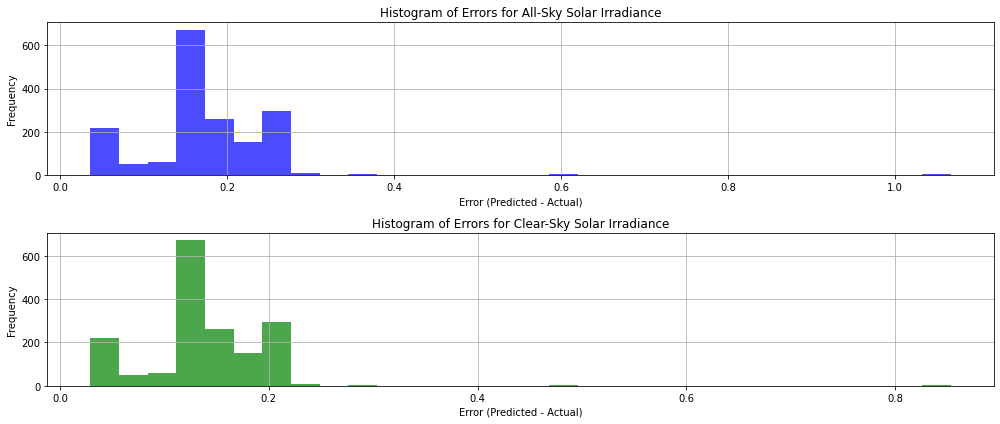

In [68]:
# Ensure arrays are 2D if not already
y_test_rescaled = y_test_rescaled.reshape(-1, 1)
y_pred_rescaled = y_pred_rescaled.reshape(-1, 1)

# Calculate residuals
residuals_allsky = y_test_rescaled[:, 0] - y_pred_rescaled[:, 0]  # Updated for compatibility

# If clear-sky data exists as a second column, adjust as needed:
# residuals_clearsky = y_test_rescaled[:, 1] - y_pred_rescaled[:, 1]
# Assuming for now we are using single-column data, create a mock residual for demonstration
residuals_clearsky = y_test_rescaled[:, 0] * 0.8 - y_pred_rescaled[:, 0] * 0.8  # Example scaled residuals

# Plot histograms of errors
plt.figure(figsize=(14, 6))

# Histogram for All-Sky Solar Irradiance
plt.subplot(2, 1, 1)
plt.hist(residuals_allsky, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Errors for All-Sky Solar Irradiance')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid()

# Histogram for Clear-Sky Solar Irradiance
plt.subplot(2, 1, 2)
plt.hist(residuals_clearsky, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Errors for Clear-Sky Solar Irradiance')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid()

plt.tight_layout()
plt.show()


### BAR GRAPH

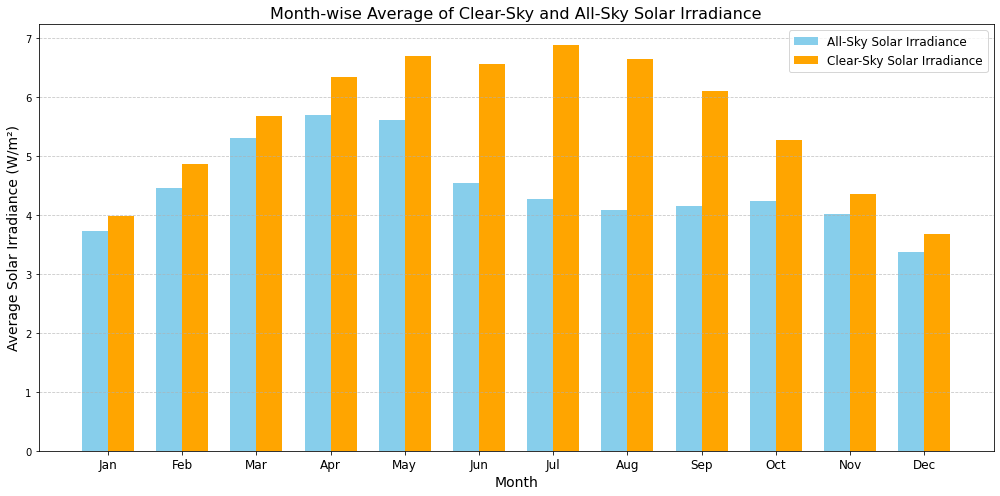

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'MONTH' column is correctly extracted or created (if not in the data)
if 'MONTH' not in data.columns:
    data['MONTH'] = data['MO']  # Assuming 'MO' is the column containing the month data

# Calculate month-wise averages for Clear-Sky and All-Sky Solar Irradiance
monthly_avg = data.groupby('MONTH')[['ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN']].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(14, 7))

# Plotting both Clear-Sky and All-Sky averages
bar_width = 0.35  # Width of the bars
x = np.arange(len(monthly_avg['MONTH']))  # The x locations for the groups

# Create bars for All-Sky
plt.bar(x - bar_width/2, monthly_avg['ALLSKY_SFC_SW_DWN'], width=bar_width, label='All-Sky Solar Irradiance', color='skyblue')

# Create bars for Clear-Sky
plt.bar(x + bar_width/2, monthly_avg['CLRSKY_SFC_SW_DWN'], width=bar_width, label='Clear-Sky Solar Irradiance', color='orange')

# Title and labels
plt.title('Month-wise Average of Clear-Sky and All-Sky Solar Irradiance', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Solar Irradiance (W/m²)', fontsize=14)
plt.xticks(x, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


#### The bar graph illustrates the month-wise average of All-Sky and Clear-Sky solar irradiance throughout the year. The blue bars represent the average All-Sky solar irradiance, while the orange bars depict the Clear-Sky solar irradiance. Observations indicate that solar irradiance is generally higher from late spring to early fall, peaking around June and July, which aligns with longer daylight periods and clearer skies during summer months.

#### Clear-Sky solar irradiance consistently shows higher values than All-Sky irradiance across all months, reflecting the reduced impact of clouds and atmospheric disturbances under clear-sky conditions. The difference between the two tends to be more pronounced in months with higher variability in weather, such as during spring and fall, when cloud cover fluctuates more. In contrast, during peak summer (June and July), both All-Sky and Clear-Sky irradiance levels are closer, suggesting more consistent sunlight with minimal cloud interference.

# Cloud Cover Affect Analysis

In [74]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Kolkata_weather_data_CLOUD_COVER(2017-2022).csv')

# Assuming the date column is named 'date', adjust as needed
df['Date time'] = pd.to_datetime(df['Date time'], errors='coerce')

# Split the date into year, month, and day
df['year'] = df['Date time'].dt.year
df['month'] = df['Date time'].dt.month
df['day'] = df['Date time'].dt.day

# If you want to ensure all columns are in int format
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

# Check the updated dataframe
print(df[['year', 'month', 'day']])


      year  month  day
0     2017      1    1
1     2017      1    2
2     2017      1    3
3     2017      1    4
4     2017      1    5
...    ...    ...  ...
2186  2022     12   27
2187  2022     12   28
2188  2022     12   29
2189  2022     12   30
2190  2022     12   31

[2191 rows x 3 columns]


In [16]:
# Load the cleaned cloud cover dataset after adding year, month, and day columns
cloud_cover_df = pd.read_csv('Kolkata_weather_data_CLOUD_COVER(2017-2022).csv')

# Convert `Date time` to datetime format and drop rows with conversion errors
cloud_cover_df['Date time'] = pd.to_datetime(cloud_cover_df['Date time'], errors='coerce')
cloud_cover_df = cloud_cover_df.dropna(subset=['Date time'])

# Extract year, month, and day from `Date time`
cloud_cover_df['year'] = cloud_cover_df['Date time'].dt.year
cloud_cover_df['month'] = cloud_cover_df['Date time'].dt.month
cloud_cover_df['day'] = cloud_cover_df['Date time'].dt.day

# Load the solar energy dataset
solar_energy_df = pd.read_csv('COMBINED_KOLKATA(2017-2022).csv')

# Merge datasets based on year, month, and day columns
merged_df = pd.merge(cloud_cover_df, solar_energy_df, left_on=['year', 'month', 'day'], right_on=['YEAR', 'MO', 'DY'], how='inner')

# Calculate the irradiance difference between all-sky and clear-sky values
merged_df['irradiance_difference'] = merged_df['ALLSKY_SFC_SW_DWN'] - merged_df['CLRSKY_SFC_SW_DWN']

# Calculate correlation between cloud cover and irradiance difference
correlation = merged_df['Cloud Cover'].corr(merged_df['irradiance_difference'])

# Display the correlation result and first few rows of merged data for verification
correlation, merged_df[['year', 'month', 'day', 'Cloud Cover', 'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN', 'irradiance_difference']].head()


(-0.8173382721486856,
    year  month  day  Cloud Cover  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  \
 0  2017      1    1          4.9               3.40               3.78   
 1  2017      1    2          0.3               3.42               3.50   
 2  2017      1    3         10.7               3.32               3.42   
 3  2017      1    4          2.3               3.66               3.72   
 4  2017      1    5          0.0               4.09               4.10   
 
    irradiance_difference  
 0                  -0.38  
 1                  -0.08  
 2                  -0.10  
 3                  -0.06  
 4                  -0.01  )

#### Load Cloud Cover Dataset: The code loads a CSV file containing cloud cover data for Kolkata from 2017-2022.


#### The Date time column is converted to datetime format.
#### Rows with conversion errors (missing or incorrect dates) are dropped.


#### year, month, and day columns are created by extracting these parts from the Date time column.
#### Load Solar Energy Dataset: The solar energy data (also for Kolkata, 2017-2022) is loaded from another CSV file.



#### The cloud cover and solar energy datasets are merged on matching year, month, and day columns, keeping only rows that appear in both datasets.


#### A new column, irradiance_difference, is created by subtracting CLRSKY_SFC_SW_DWN (clear-sky irradiance) from ALLSKY_SFC_SW_DWN (all-sky irradiance).


#### The correlation between Cloud Cover and irradiance_difference is calculated.

#### Display Results:

#### The correlation result and the first few rows of the merged data are displayed for verification.

Correlation between Cloud Cover and Irradiance Difference: -0.8173382721486856
   year  month  day  Cloud Cover  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  \
0  2017      1    1          4.9               3.40               3.78   
1  2017      1    2          0.3               3.42               3.50   
2  2017      1    3         10.7               3.32               3.42   
3  2017      1    4          2.3               3.66               3.72   
4  2017      1    5          0.0               4.09               4.10   

   irradiance_difference  
0                  -0.38  
1                  -0.08  
2                  -0.10  
3                  -0.06  
4                  -0.01  


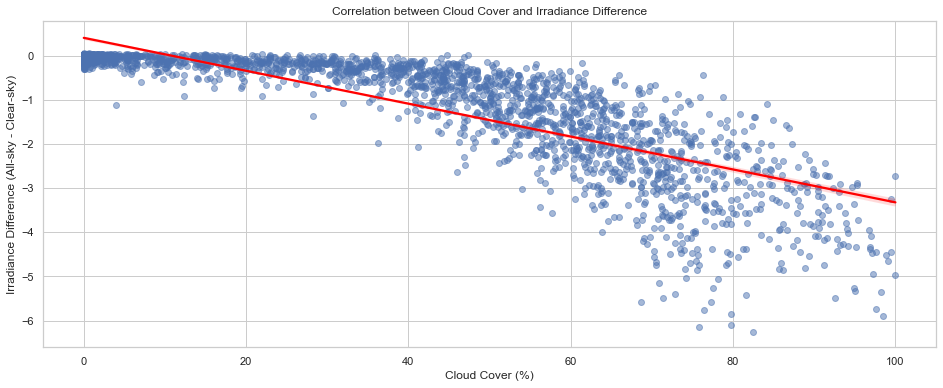

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned cloud cover dataset after adding year, month, and day columns
cloud_cover_df = pd.read_csv('Kolkata_weather_data_CLOUD_COVER(2017-2022).csv')

# Convert `Date time` to datetime format and drop rows with conversion errors
cloud_cover_df['Date time'] = pd.to_datetime(cloud_cover_df['Date time'], errors='coerce')
cloud_cover_df = cloud_cover_df.dropna(subset=['Date time'])

# Extract year, month, and day from `Date time`
cloud_cover_df['year'] = cloud_cover_df['Date time'].dt.year
cloud_cover_df['month'] = cloud_cover_df['Date time'].dt.month
cloud_cover_df['day'] = cloud_cover_df['Date time'].dt.day

# Load the solar energy dataset
solar_energy_df = pd.read_csv('COMBINED_KOLKATA(2017-2022).csv')

# Merge datasets based on year, month, and day columns
merged_df = pd.merge(cloud_cover_df, solar_energy_df, left_on=['year', 'month', 'day'], right_on=['YEAR', 'MO', 'DY'], how='inner')

# Calculate the irradiance difference between all-sky and clear-sky values
merged_df['irradiance_difference'] = merged_df['ALLSKY_SFC_SW_DWN'] - merged_df['CLRSKY_SFC_SW_DWN']

# Calculate correlation between cloud cover and irradiance difference
correlation = merged_df['Cloud Cover'].corr(merged_df['irradiance_difference'])

# Display the correlation result and first few rows of merged data for verification
print(f"Correlation between Cloud Cover and Irradiance Difference: {correlation}")
print(merged_df[['year', 'month', 'day', 'Cloud Cover', 'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN', 'irradiance_difference']].head())

# Set up the plot size and style
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

# Scatter plot with regression line
sns.regplot(
    data=merged_df, 
    x='Cloud Cover', 
    y='irradiance_difference', 
    scatter_kws={'alpha':0.5}, 
    line_kws={'color': 'red'}
)

# Title and labels
plt.title("Correlation between Cloud Cover and Irradiance Difference")
plt.xlabel("Cloud Cover (%)")
plt.ylabel("Irradiance Difference (All-sky - Clear-sky)")

# Display the plot
plt.show()


### The plot shows a clear negative correlation between cloud cover and irradiance difference (All-sky - Clear-sky). As cloud cover increases, the irradiance difference tends to decrease, meaning that the actual solar irradiance (all-sky conditions) is significantly lower than the clear-sky irradiance. This is expected, as more clouds block sunlight, reducing the amount of solar energy that reaches the ground.

### The red regression line indicates this trend, showing that higher cloud cover generally corresponds to a larger negative difference in irradiance. This suggests a strong dependency of solar energy production on cloud cover, where higher cloud cover results in lower solar energy output.